In [1]:
import numpy as np
import autograd.numpy as np
from autograd import elementwise_grad
import matplotlib.pyplot as plt
import seaborn as sns
from FeedForwardNeuralNetwork import NeuralNetwork

In [2]:
mu = 0; sigma = 0.1

# Functions copied from frankefunction.py
def franke_function(x, y, noise = False):
    n= len(x)

    term1 =  0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 =  0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 =  0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)

    if noise:
        normal_dist = np.random.normal(mu, sigma, (n,n))
        return term1 + term2 + term3 + term4 + normal_dist #, np.var(normal_dist)
    else:
        return term1 + term2 + term3 + term4    

# Taken directly from split_scale.py
def design_matrix(x, y, deg):

    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    p = int((deg + 1)*(deg + 2)/2)
    X = np.ones((N,p))

    for i in range(1, deg + 1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = x**(i-k) * y**k
            
    return X

# Taken from functions.py
def make_heat_map(matrix, x_axis, y_axis, fmt= ".2f", vmin= None, vmax= None):
    plt.figure()
    
    if fmt[-1] == "f":
        np.around(matrix, int(fmt[-2]))
    
    
    if vmin == None and vmax == None:
        vmin = matrix.max()
        vmax = matrix.min()
    
    ax = sns.heatmap(matrix, xticklabels= x_axis, yticklabels= y_axis,\
                     annot= True, fmt= fmt, vmin= vmin, vmax= vmax)
    # if vmin != None and vmax != None:
    #     ax = sns.heatmap(matrix, xticklabels= x_axis, yticklabels= y_axis,\
    #                      annot= True, fmt= fmt, vmin= vmin, vmax= vmax)
    # else:
    #     ax = sns.heatmap(matrix, xticklabels= x_axis, yticklabels= y_axis,\
    #                      annot= True, fmt= fmt)    

# Taken from functions.py
def save_fig(name):
    plt.savefig(name, dpi= 180, bbox_inches= 'tight')

# Modified version of the one in functions.py
def analysis(X_train, y_train, X_test, y_test, epochs= 5, cost= "MSE", analysis= "batch_size",\
             activation= "sigmoid", last_activation= None, batch_size= None, lmbd= 0.001, gamma= 0.2, nr_of_hidden_layers = 1, nr_of_hidden_nodes  = 20):
    etas  = np.logspace(-4, -1, 4)
#     etas  = np.logspace(-2, -1.01, 4)
    
    if batch_size == None:
        if cost in ["mse", "MSE"]:
            batch_sizes = [20, 40, 80, 160] # Franke
        else:
            batch_sizes = [13, 35, 65, 91]  # Logistic regression cancer [5, 7, 13, 35, 65, 91]
    else:
        batch_size = batch_size
    
    NN = NeuralNetwork(
                     X                   = X_train,
                     y                   = y_train,
                     nr_of_hidden_layers = nr_of_hidden_layers,
                     nr_of_hidden_nodes  = nr_of_hidden_nodes,
                     batch_size          = batch_size,
                     eta                 = None,
                     lmbd                = None,
                     gamma               = gamma,
                     activation          = activation,
                     last_activation     = last_activation,
                     cost                = cost)
    
    
    print(f"gamma for SGD momentum: {NN.gamma}")
    if cost in ["mse", "MSE"]:
        error_func = NN.MSE_score
#         error_func = NN.R2_score
    else:
        error_func = NN.accuracy_score
    
    if analysis in ["batch_size", "batch size", "Batch size"]:
        NN.lmbd = lmbd
        error_cache = np.zeros([len(etas), len(batch_sizes)])
        stops = error_cache.copy()
        for e, eta in enumerate(etas):
            for l, batch_size in enumerate(batch_sizes):
                NN.e = eta
                NN.batch_size = batch_size
#                 epochs = int(2)
                NN.train(epochs) # 50 Epochs
                stop = NN.get_nr_of_epochs()
                
                error_cache[e][l] = error_func(X_test, y_test) 
                stops[e][l] = stop
        
        col_mean = np.mean(error_cache, axis= 0)
        if cost in ["mse", "MSE"]:
            optimal_idx = np.where(col_mean == col_mean.min())[0][0] # if MSE score
#             optimal_idx = np.where(col_mean == col_mean.max())[0][0] # if R2 score
        else:
            optimal_idx = np.where(col_mean == col_mean.max())[0][0]
        
        optimal_batch_size = batch_sizes[optimal_idx]
        
        print("\n Optimal batch size:", optimal_batch_size)
#         print("\n Optimal batch size:", optimal_batch_size, nr_of_hidden_layers, nr_of_hidden_nodes)
        return stops, error_cache, etas, batch_sizes, optimal_batch_size
    elif analysis in ["hyperparameter", "hyper", "HYPER"]:
        lmbds = np.logspace(-5, -1, 5)
        #lmbds = np.logspace(-5, -4, 2)
        error_cache = np.zeros([len(etas), len(lmbds)])
        stops = error_cache.copy()
        for e, eta in enumerate(etas):
            for l, lmbd in enumerate(lmbds):
                NN.e    = eta
                NN.lmbd = lmbd
#                 epochs = int(2)
                NN.train(epochs) # 50 Epochs
                stop = NN.get_nr_of_epochs()
                error_cache[e][l] = error_func(X_test, y_test) 
                stops[e][l] = stop
        return stops, error_cache, etas, lmbds
    
# Modified version of the initialize_array in frankefunction.py
def generate_data(N, deviation):
    xx   = np.linspace(0, 1, N)
    yy   = np.linspace(0, 1, N)
    x, y = np.meshgrid(xx, yy)
    
    z = franke_function(x, y, noise= True)
    z = z.reshape(N**2, 1)
    
    return x, y, z
    
def scikit_scaler(X_train, X_test):
    
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.fit_transform(X_test)
    
    return X_train_scaled, X_test_scaled

x, y, z:  (20, 20) (20, 20) (400, 1)
Design matrix: (400, 21)
gamma for SGD momentum: 0.2

 Optimal batch size: 160
Bacht size stopped at 5.0 CHANGE TITLE BETWEEN MSE AND R2!!!!!
gamma for SGD momentum: 0.2

Hyper stopped at 5.0


Text(33.0, 0.5, '$\\log(\\eta)$')

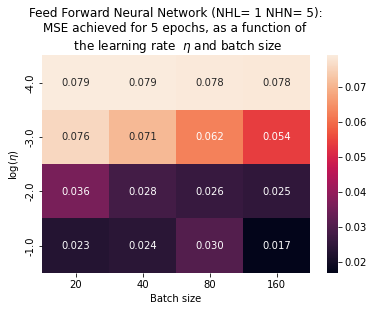

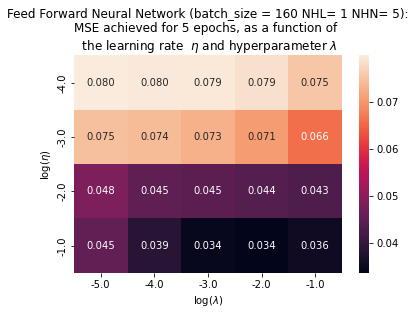

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# The above imports numpy as np so we have to redefine:
N = 20                # Number of points in each dimension
deviation = 0.1       # Added noise to the z-value
deg = 5               # Highest order of polynomial for X

# batch_size = int(N * N * 0.8)
x, y, z = generate_data(N, deviation)
print("x, y, z: ", x.shape, y.shape, z.shape)
#X = create_X(x, y, deg)
X = design_matrix(x, y, deg)
print(f"Design matrix: {X.shape}")
X_train, X_test, Z_train, Z_test = train_test_split(X, z, test_size=0.2)
X_train, X_test = scikit_scaler(X_train, X_test) ####

#Presets
epochs = 5
cost= "MSE"                # "cross_entropy" "MSE"
activation= "ReLU"         # "sigmoid" "ReLU" "Leaky_ReLU" "Softmax"
last_activation= "sigmoid" # None "sigmoid" "ReLU" "Leaky_ReLU" "Softmax"

lmbd = 0.
# Sigmoid
# NHL 1 3 5
# NHN 5 20 40 100
# ReLU Leaky_ReLU
# NHL 2 3 4
# NHN 3 4 5
NHL = 1
NHN = 5

# batch size analysis
stops, error_score, etas, batch_sizes, optimal_batch_size =\
analysis(X_train, Z_train, X_test, Z_test, epochs= epochs, cost= cost, analysis= "batch_size",\
         activation= activation, last_activation= last_activation, lmbd= lmbd, nr_of_hidden_layers = NHL, nr_of_hidden_nodes = NHN)

print(f"Bacht size stopped at {stops.min()} CHANGE TITLE BETWEEN MSE AND R2!!!!!")
make_heat_map(error_score, batch_sizes, np.around(np.log10(etas), 2), fmt= ".3f") # np.log10(etas) np.around(np.log10(etas), 2)
title_string1 = f"Feed Forward Neural Network (NHL= {NHL} NHN= {NHN}):\n"
title_string2 = f"MSE achieved for {epochs} epochs, as a function of \n the learning rate  $\eta$ and batch size"
title_string = title_string1 + title_string2
plt.title(title_string, fontsize= 12)
plt.xlabel(r"Batch size"); plt.ylabel(r"$\log(\eta)$")
# save_fig(f"Figures/FFNN-batch-{cost}-{activation}-{NHL}-{NHN}.png")

# lambda analysis
stops, error_score, etas, lmbds =\
analysis(X_train, Z_train, X_test, Z_test, epochs= epochs, cost= cost, analysis= "hyper",\
         activation= activation, last_activation= last_activation, batch_size= optimal_batch_size, nr_of_hidden_layers = NHL, nr_of_hidden_nodes  = NHN)

print(f"\nHyper stopped at {stops.min()}")
make_heat_map(error_score, np.log10(lmbds), np.around(np.log10(etas), 2), fmt= ".3f") # np.log10(etas) np.around(np.log10(etas), 2)
title_string1 = f"Feed Forward Neural Network (batch_size = {optimal_batch_size} NHL= {NHL} NHN= {NHN}):\n"
title_string2 = f"MSE achieved for {epochs} epochs, as a function of \n the learning rate  $\eta$ and hyperparameter $\lambda$"
title_string = title_string1 + title_string2
plt.title(title_string, fontsize= 12)
plt.xlabel(r"$\log(\lambda)$"); plt.ylabel(r"$\log(\eta)$")
# save_fig(f"Figures/FFNN-hyper-{cost}-{activation}-{NHL}-{NHN}.png")

In [4]:
error_score = error_score # Regression Franke
index = np.where(error_score == np.min(error_score)) #if MSE
# index = np.where(error_score == np.max(error_score)) #if R2 Score

print(index, index[0][0], index[1][0])
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

nr_of_hidden_nodes  = NHN
nr_of_hidden_layers = NHL


scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2) # Franke

scaler.fit(X_train)
X_train = scaler.transform(X_train)

scaler.fit(X_test)
X_test = scaler.transform(X_test)

NN_sk = MLPRegressor(hidden_layer_sizes = [nr_of_hidden_nodes for i in range(nr_of_hidden_layers)],
        activation         = "logistic",
        alpha              = lmbds[index[1][0]],
        learning_rate_init = etas[index[0][0]],
        max_iter           = epochs)


NN_sk.fit(X_train, y_train)
predict  = NN_sk.predict(X_test)
# accuracy = r2_score(y_test, NN_sk.predict(X_test))
accuracy = mean_squared_error(y_test, NN_sk.predict(X_test))

print(f"The MSE for the FFNN was {error_score[index[0][0]][index[1][0]]:.2f}")
print(f"The MSE for the SK-learn MLP was {accuracy:.2f}")

(array([3]), array([3])) 3 3
The MSE for the FFNN was 0.03
The MSE for the SK-learn MLP was 0.04


/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


gamma for SGD momentum: 0.2

 Optimal batch size: 91
Bacht size stopped at 5.0
gamma for SGD momentum: 0.2

Hyper stopped at 5.0


Text(33.0, 0.5, '$\\log(\\eta)$')

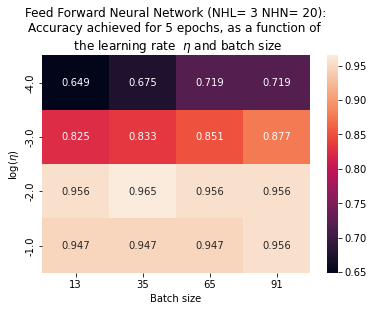

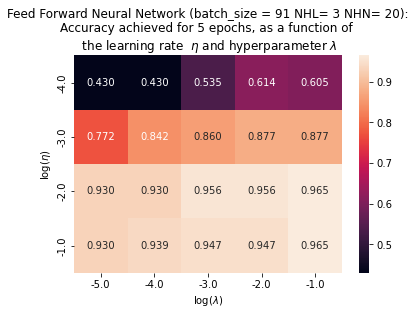

In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cancer = load_breast_cancer()

inputs  = cancer.data
outputs = cancer.target
labels  = cancer.feature_names[0:30]

xx = inputs
y = outputs.reshape((len(outputs), 1))

X = np.reshape(xx[:, 1], (len(xx[:, 1]), 1))
features = range(1, 30)
for i in features:
    temp = np.reshape(xx[:, i], (len(xx[:, i]), 1))
    X = np.hstack((X, temp))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_test = scikit_scaler(X_train, X_test) ####

#Presets
epochs = 5
cost= "cross_entropy" # "cross_entropy" "MSE"
activation= "Sigmoid" # "sigmoid" "ReLU" "Leaky_ReLU" "Softmax"
last_activation= None # None "sigmoid" "ReLU" "Leaky_ReLU" "Softmax"

lmbd = 0.
# Sigmoid
# NHL 1 3 5
# NHN 5 20 40 100
# ReLU Leaky_ReLU
# NHL 1 3 5
# NHN 10 20 30
NHL = 3
NHN = 20

# batch size analysis
stops, accuracy_score, etas, batch_sizes, optimal_batch_size =\
analysis(X_train, y_train, X_test, y_test, epochs= epochs, cost= cost, analysis= "batch_size",\
         activation= activation, last_activation= last_activation, lmbd= lmbd, nr_of_hidden_layers = NHL, nr_of_hidden_nodes = NHN)

print(f"Bacht size stopped at {stops.min()}")
make_heat_map(accuracy_score, batch_sizes, np.around(np.log10(etas), 2), fmt= ".3f") # np.log10(etas) np.around(np.log10(etas), 2)
title_string1 = f"Feed Forward Neural Network (NHL= {NHL} NHN= {NHN}):\n"
title_string2 = f"Accuracy achieved for {epochs} epochs, as a function of \n the learning rate  $\eta$ and batch size"
title_string = title_string1 + title_string2
plt.title(title_string, fontsize= 12)
plt.xlabel(r"Batch size"); plt.ylabel(r"$\log(\eta)$")
# save_fig(f"Figures/FFNN-batch-{cost}-{activation}-{NHL}-{NHN}.png")

# lambda analysis
stops, accuracy_score, etas, lmbds =\
analysis(X_train, y_train, X_test, y_test, epochs= epochs, cost= cost, analysis= "hyper",\
         activation= activation, last_activation= last_activation, batch_size= optimal_batch_size, nr_of_hidden_layers = NHL, nr_of_hidden_nodes  = NHN)

print(f"\nHyper stopped at {stops.min()}")
make_heat_map(accuracy_score, np.log10(lmbds), np.around(np.log10(etas), 2), fmt= ".3f") # np.log10(etas) np.around(np.log10(etas), 2)
title_string1 = f"Feed Forward Neural Network (batch_size = {optimal_batch_size} NHL= {NHL} NHN= {NHN}):\n"
title_string2 = f"Accuracy achieved for {epochs} epochs, as a function of \n the learning rate  $\eta$ and hyperparameter $\lambda$"
title_string = title_string1 + title_string2
plt.title(title_string, fontsize= 12)
plt.xlabel(r"$\log(\lambda)$"); plt.ylabel(r"$\log(\eta)$")
# save_fig(f"Figures/FFNN-hyper-{cost}-{activation}-{NHL}-{NHN}.png")

In [6]:
error_score = accuracy_score # Classification cancer data 
index = np.where(error_score == np.max(error_score))

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, r2_score

nr_of_hidden_nodes = NHN
nr_of_hidden_layers = NHL

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # cancer data

scaler.fit(X_train)
X_train = scaler.transform(X_train)

scaler.fit(X_test)
X_test = scaler.transform(X_test)

NN_sk = MLPClassifier(hidden_layer_sizes = [nr_of_hidden_nodes for i in range(nr_of_hidden_layers)],
        activation         = "logistic",
        alpha              = lmbds[index[1][0]],
        learning_rate_init = etas[index[0][0]],
        max_iter           = epochs)

NN_sk.fit(X_train, y_train)
predict  = NN_sk.predict(X_test)
accuracy = accuracy_score(y_test, NN_sk.predict(X_test))

print(f"The accuracy for the FFNN was {100*error_score[index[0][0]][index[1][0]]:.2f}%")
print(f"The accuracy for the SK-learn MLP was {100*accuracy:.2f}%")

The accuracy for the FFNN was 96.49%
The accuracy for the SK-learn MLP was 58.77%


/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
